# Aula 5: Aproximação e mínimos quadrados

Na aula passado demos uma visão geral do que se quer neste curso e começamos a falar de aproximação. Os seguintes assuntos foram abordados:

 * Introdução à interpolação
 * Interpolação polinomial utilizando a matriz de Vandermonde
 * Interpolação polinomial com diferenças divididas
 * Interpolação polinomial com polinômios de Lagrange
 * Dificuldades com interpolação polinomial
 
Os exercícios propostos mostraram sérias dificuldades na interpolação polinomial de funções relativamente simples como a função de Runge

$$
f(x) = \frac{1}{1 + 25x^2}
$$

Mudando a posição ou usando um outro esquema de interpolação como *splines* por exemplo pode reduzir as oscilações significativamente para a função de Runge. 

Uma outra dificuldade é quando existem possíveis erros nos dados que foram usados na interpolação. Obrigar que a curva passe exatamente em cada ponto pode não ser a melhor idéia neste contexto. 

Outra possibilidade é usar uma aproximação que não necessariamente precisa passar em cada ponto mas o erro é minimizado de alguma maneira. A técnica mais comum é o método dos mínimos quadrados

In [1]:
using PyPlot

# Introdução ao método dos mínimos quadrados

Imaginemos que temos uma sequência de pontos e queremos encontrar a reta que melhor se ajusta a estes pontos:


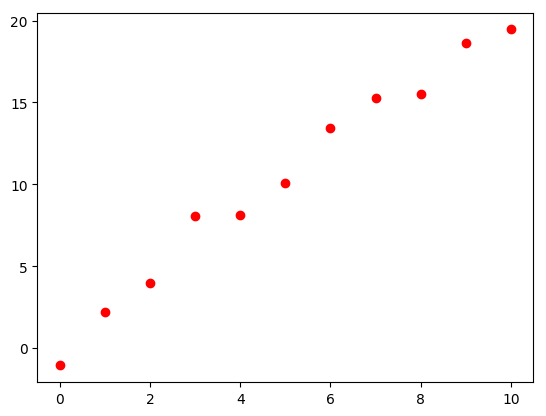

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f833da61358>

In [2]:
x = 0.0:10.0
y = 2*x + randn(length(x));

plot(x, y, "ro")

Existem várias maneiras de se estimar este erro:

Uma possibilidade é considerar o erro máximo de todos os pontos
$$ \varepsilon_\infty(a_0, a_1) = \max_{1\le i\le N} \left[ \left|(a_0 + a_1 x_i) - y_i\right|\right]$$
esta minimização é conhecida como **minimax** na literatura e não é algo simples de se conseguir.

Outra possibilidade é minimizar o desvio absoluto:
$$
\varepsilon_1(a_0, a_1) = \sum_{i=1}^N \left|(a_0 + a_1 x_i) - y_i\right|
$$
Esta função não é diferenciável para desvios nulos o que dificulta o problema.

Uma abordagem mais conveniente e a mais utilizada na prática é o método dos mínimos quadrados:

$$
\varepsilon_2(a_0, a_1) = \sum_{i=1}^N \left[(a_0 + a_1 x_i) - y_i\right]^2
$$

Para se minimizar $\varepsilon_2$, basta derivar em relação a $a_0$ e $a_1$ e igualar a zero. Com isso chega-se ao seguinte sistema de equações lineares:
$$
a_0\cdot N + a_1\sum_{i=1}^N x_i = \sum_{i=1}^N y_i\\
a_0\sum_{i=1}^N x_i + a_1\sum_{i=1}^N x_i^2 = \sum_{i=1}^N x_i y_i\\
$$

Resolvendo este sistema linear, calculam-se os coeficientes desejados.

In [3]:
function linear_fit(x, y)

    
    sx = sum(x)
    sy = sum(y)

    m = length(x)

    sx2 = zero(sx)
    sy2 = zero(sy)
    sxy = zero(sx*sy)

    for i = 1:m
        sx2 += x[i]*x[i]
        sy2 += y[i]*y[i]
        sxy += x[i]*y[i]
    end

    a0 = (sx2*sy - sxy*sx) / ( m*sx2 - sx*sx )
    a1 = (m*sxy - sx*sy) / (m*sx2 - sx*sx)

    return (a0, a1)
end

linear_fit (generic function with 1 method)

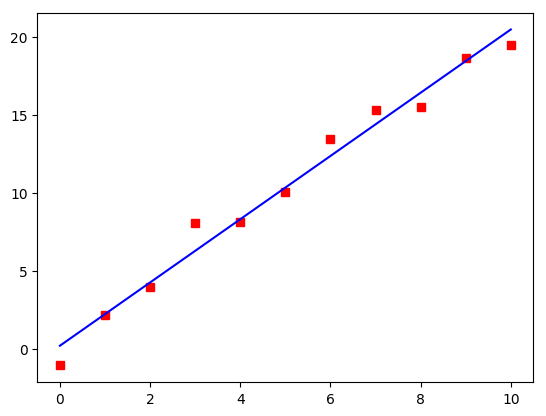

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f833b2f9240>

In [4]:
a0, a1 = linear_fit(x, y)

plot(x, y, "rs")
plot(x, a0 .+ a1*x, "b-")

# Será que dá para generalizar?

É comum que se queira forçar que a reta passe pela origem. Ou se queira ajustar uma parábola ou um polinômio de ordem n qualquer. Pode-se desejar utilizar outras funções de ajuste.

Aqui será proposto uma abordagem mais genérica para o ajuste de curva. O problema de ajuste de curva utilizando o método dos mínimos quadrados linear consiste em encontrar os coeficiente $a_i$ da expressão a seguir
$$
y^\delta(x) = \sum_{i=1}^n a_i\phi_i(x)
$$
que minimiza o erro:
$$
\varepsilon_2 = \sum_{k=1}^m \left\{ \left[\sum_{i=1}^n a_i\phi_i(x_k)\right]^2 - y_k\right\}
$$
como os pontos $x_k$ são conhecidos, pode-se escrever isso como
$$
\varepsilon_2 = \sum_{k=1}^m \left[ \left(\sum_{i=1}^n a_i\phi_{ki}\right)^2 - y_k\right]
$$
onde $\phi_{ki} = \phi_i(x_k)$

Para se minimizar este erro, devemos calcular as derivadas
$$
\frac{\partial\varepsilon_2}{\partial a_j} = 0 \qquad 1 \le j \le n
$$

Com isso, chegamos ao seguinte sistema linear:
$$
\sum_{i=1}^n\left[ \sum_{k=1}^m \phi_{ki}\phi_{kj}\right] = \sum_{k=1}^m y_k\phi_{kj} \qquad 1 \le j \le n
$$

Para o caso de uma reta, 
$$
\phi_{k1} = 1\\
\phi_{k2} = x_k
$$
onde se chega ao sistema linear obtido acima.

Caso se deseje qua a reta passe pela origem, basta fazer com quq n=1 e $\phi_{k1} = x_k$. Assim, a solução tem a seguinte forma:

$$
a = \frac{\sum_{i=1}^m x_i y_i}{\sum_{i=1}^m x_i^2}
$$

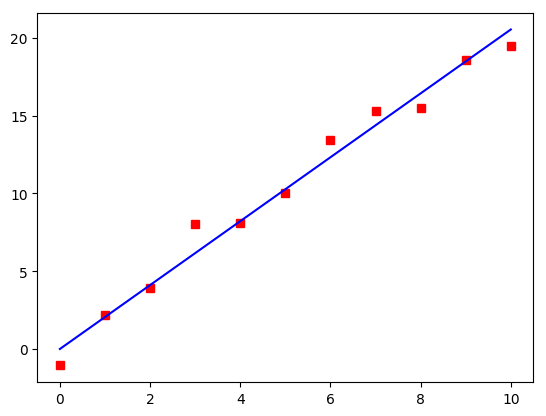

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f833b3ca208>

In [5]:
a = sum(x .* y) / sum(x .* x)

plot(x, y, "rs")
plot(x, a*x, "b-")

In [6]:
function least_squares(y, ϕ)
    m = length(y)
    n = size(ϕ, 2)
    
    if size(ϕ,1) != m
        error("O número de linhas de ϕ deve ter o mesmo comprimento de x e y")
    end
    A = zeros(n,n)
    b = zeros(n)
    s = 0.0
    for i = 1:n
        for j in 1:i
            s = 0.0
            for k = 1:m
                s += ϕ[k,i] * ϕ[k,j]
            end
            A[j,i] = s
            A[i,j] = s
        end
        s = 0.0
        for k = 1:m
            s += y[k] * ϕ[k,i]
        end
        b[i] = s
    end
    
    return A\b
    
end


least_squares (generic function with 1 method)

In [7]:
n = length(x)
ϕ = zeros(n, 2)
ϕ[:,1] .= 1.0
ϕ[:,2] .= x

fit = least_squares(y, ϕ)
fit[1] - a0, fit[2] - a1

(1.0325074129013956e-14, -8.881784197001252e-16)

In [8]:
ϕ₀ = collect(x)
aa = least_squares(y, ϕ₀)[1]

aa ≈ a

true

In [9]:
f(x) = 1.0 + x*(2.0 + 3.0x)
x1 = 0:0.5:5
y1 = f.(x1)
nx = length(x1)
ϕ₂ = [fill(1.0, nx) x1 x1.*x1]
fit = least_squares(y1, ϕ₂)

fit[1] ≈ 1.0, fit[2] ≈ 2.0, fit[3]≈3.0

(true, true, true)

# Esta formulação é bem genérica

Vamos imaginar que estamos fazendo um experimento de transferência de calor e desejamos ajustar uma curva para o número de Nusselt:

$$
Nu = a_0\cdot Re^a_1 \cdot Pr^a_2
$$

Como determinar os coeficientes acima?

In [10]:
# Colocando uns números aleatŕios:
np = 100
Re = 3960 * rand(np) .+ 40  # Reynolds entre 40 e 4000
Pr = rand(np) .+ 0.5 # Pr entre 0.5 e 1.5

Nu = 0.683 * Re.^0.466 .* Pr.^ 0.3333;

In [11]:
ϕ₃ = [fill(1.0, np) log.(Re) log.(Pr)]

fit = least_squares(log.(Nu), ϕ₃)

a₀, a₁, a₂ = exp(fit[1]), fit[2], fit[3]

a₀≈0.683, a₁≈0.466, a₂≈0.3333

(true, true, true)

# E uma função para ajuste polinomial genérica?

In [12]:
function poly_fit(x, y, ndeg)
    n = ndeg + 1
    m = length(x)
    
    ϕ = zeros(m, n)
    ϕ[:,1] .= 1.0
    for i = 2:n
        ϕ[:,i] .= x .^ (i-1)
    end
    
    return least_squares(y, ϕ)
end


poly_fit (generic function with 1 method)

In [13]:
poly_fit(x1, y1, 2)

3-element Array{Float64,1}:
 0.9999999999999752
 2.000000000000035 
 2.999999999999993 

In [14]:
poly_fit(x1, y1, 3)

4-element Array{Float64,1}:
 0.9999999999998569    
 2.00000000000042      
 2.9999999999997913    
 2.6842725573161148e-14

In [15]:
poly_fit(x1, y1, 5)

6-element Array{Float64,1}:
  0.9999999999975834    
  2.000000000029302     
  2.9999999999555516    
  2.3725568241700458e-11
 -5.223032918570984e-12 
  4.0537859867421526e-13

# Será que esta é a melhor abordagem para ajuste polinomial?

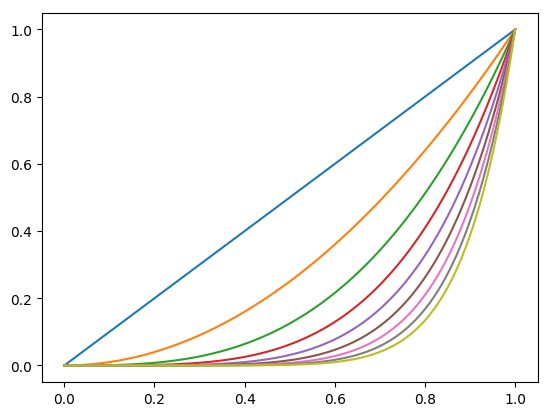

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f833b3b42b0>

In [16]:
xx = 0:0.01:1
plot(xx, xx)
plot(xx, xx.^2)
plot(xx, xx.^3)
plot(xx, xx.^4)
plot(xx, xx.^5)
plot(xx, xx.^6)
plot(xx, xx.^7)
plot(xx, xx.^8)
plot(xx, xx.^9)



### Normas

Agora precisamos pensar usando álgebra linear. Podemos definir $P_n^{a,b}$ que é o espaço dos polinômios de 
grau igual ou menor a n definidos no intervalo $a \le x \le b$

Com $f,g \in P_n^{a,b}$ e $\alpha,\beta\in \mathcal{R}$, podemos definir as operações de adição, multiplicação por um número real. Isto satisfaz a definição de um espaço vetorial (lembra de álgebra linear???). Definindo uma norma, temos um espaço vetorial com norma. 

Como se poderia definir uma norma? Existem algumas possibilidades:

$$
\left\| f \right\|_\infty = \max_{a\le x \le b} \left| f(x)\right|
$$

ou 

$$
\left\| f \right\|_1 = \int_a^b \left| f(x) \right| \: dx
$$

ou 

$$
\left\| f \right\|_2 = \int_a^b f^2(x) \: dx \qquad\text{Norma Euclidiana}
$$

ou de uma maneira mais geral:
$$
\left\| f \right\|_p = \int_a^b \left|f(x)\right|^p \: dx
$$

### Produto interno 

Também podemos definir um produto interno:
$$
\langle f, g \rangle = \int_a^b f(x)\cdot g(x) \:dx
$$

Esse produto interno gera a norma Euclidiana:
$$
\langle f, f \rangle = \int_a^b f^2(x) \:dx \equiv \left\| f \right\|_2
$$

Pode ser conveniente usar um peso:
$$
\langle f, g \rangle_w = \int_a^b w(x) \cdot f(x)\cdot g(x) \:dx
$$



### Bases e bases ortogonais

Qualquer polinômio de grau n, pode ser escrito como
$$
p_n(x) = a_0 + a_1 x + a_2 x^2 + \cdots + a_n x^n = \sum_{i=0}^n a_i x^i
$$
As funções $x^i$ para $0\le i\le n$ formam uma base para o espaço dos polinômios de grau n. Mas esta base não é ortogonal. Usando algum processo de ortogonalização, por exemplo Gram-Schmidt pode-se chegar a uma base ortogonal.

Para polinômios definidos em $-1\le x \le 1$, o processo de ortogonalização leva aos polinômios de Legendre:
$$
\langle L_n, L_m \rangle = \int_{-1}^1 L_n(x) L_m(x)\:dx = \frac{2}{2n + 1} \delta_{nm}
$$

Para o peso da forma 
$$
w(x) = \left(1 - x\right)^\alpha  \left(1 + x\right)^\beta
$$
chegamos aos polinômios de Jacobi $P^{(\alpha,\beta)}_n(x)$:
$$
\int_{-1}^1 \left(1 - x\right)^\alpha  \left(1 + x\right)^\beta P^{(\alpha,\beta)}_n(x) P^{(\alpha,\beta)}_m(x) \:dx = \frac{2^{\alpha + \beta + 1}}{2n + \alpha + \beta + 1} \frac{\Gamma(n+\alpha+1)\Gamma(n+\beta+1)}{\Gamma(n + \alpha + \beta + 1)n!} \cdot \delta_{nm}
$$

# Aproximação

## Teorema da aproximação de Weierstrass

Suponha que f é definida e contínua em $[a,b]$. Para cada $\varepsilon > 0$, existe um polinômio $P(x)$ com a propriedade que 

$$
\left| f(x) - P(x) \right| < \varepsilon \qquad \text{Para todo } x \in [a,b]
$$

Além de polinômios serem práticos e fáceis de usar, também permitem aproximar quaisquer função contínua.


## Polynômios de Chebyshev $T_n(x)$

Demonstra-se que os polinômios de Chebyshev são os que melhor aproximam funções suaves. Os polinômios de Chebyshev estão diretamente relacionados aos polinômios de Jacobi:

$$
T_n(x) = c_n \cdot P_n^{(-\frac{1}{2},-\frac{1}{2})}(x)
$$

de modo que

$$
\int_{-1}^1 \frac{T_n(x) T_m(x)}{\sqrt{1-x^2}}\:dx = \left\{\begin{matrix}0 & n\ne m\\ \pi & n=m=0\\ \frac{\pi}{2} & n=m\ne 0\end{matrix}\right.
$$

Está relacionado com a função consseno:
$$
T_n(x) = \cos\left(n\arccos x\right)
$$

Lembram dos pontos $\cos\left(\frac{k \pi}{N}\right)$ para $0 \le k \le N$? Estão relacionados com os extremos de $T_n(x)$ e os zeros de $T_n(x)$ são 
$$
x_k = \cos\left[\frac{\left(k + \frac{1}{2}\right)\pi}{n}\right], \qquad k = 0, \ldots, n-1
$$

# Como aproximar funções?

Seja uma função $f(x)$ como representá-las por outras funções mais simples ou convenientes?
$$
f(x) \approx g(x) = \sum_{i=1}^n a_i\phi_i(x)
$$

Precisamos determinar $a_i$ para a família de funções $\phi_i(x)$. Daí surgem duas questões:

 * Que família $\phi_i(x)$ escolher? (qual a base que vamos usar)
 * Como calcular $a_i$?

## Método dos resíduos ponderados

Queremos minimizar o erro da representação. O erro é dados por 
$$
\varepsilon(x) = \sum_{i=1}^n a_i\phi_i(x) - f(x)
$$

Então escolhemos uma família de pesos $w_k(x)$ de modo que 
$$
\int_a^b w(x)\varepsilon(x)\:dx = 0 \quad\longrightarrow\quad \int_a^b w_k(x) \cdot f(x) \:dx = \int_a^b w_k(x) \cdot \left[\sum_{i=1}^n a_i\phi_i(x)\right] \:dx 
$$

### Método da colocação
Uma possibilidade é escolher alguns pontos $x_k$ e impor que a aproximação seja exata *nesses pontos*

$$
\sum_{i=1}^n a_i\phi_i(x_k) = f(x_k)
$$
Esta situação consiste em escolher os pesos como
$$
w_k(x) = \delta(x-x_k)
$$
Onde $\delta(x)$ é o $\delta$ de Dirac.

### Método dos mínimos quadrados
Outra possibilidade é minimizar o quadrado do erro:
$$
E(a_1, a_2, \ldots, a_n) = \int_a^b \varepsilon^2(x)\:dx
$$
O mínimo ocorre quando
$$
\frac{\partial E}{\partial a_k} = 0 \qquad k = 1, \ldots, n
$$
Para se fazer isso, basta usar os pesos
$$
w_k(x) = \frac{\partial\varepsilon}{\partial a_k}
$$

### Método dos volumes finitos

Divide-se o domínio em elementos adjacentes separados pelos pontos $a = x_0 < x_1 < x_2 < \ldots < x_n=b$
Definimos o elemento $V_k$ como a região com $x_{k-1} \le x \le x_k$ onde $k=1, \ldots, n$. 

O peso $w_k(x)$ vale:
$$
w_k(x) = \left\{ \begin{matrix} 1 & x\in V_k \\ 0 & x \not\in V_k \end{matrix}\right.
$$


### Método de Galerkin
Usam-se as mesmas funções para aproximar e minimizar o erro:
$$
w_k(x) = \phi_k(x)
$$

Assim, 
$$
\int_a^b \left\{\phi_k(x) \sum_{i=1}^n a_i\phi_i(x)\right\}\:dx = \int_a^b \phi_k(x) f(x)\:dx
$$
O que se transforma em 
$$
\left[M\right]\left\{a\right\} = \left\{F\right\}
$$
onde 
$$
M_{ki} = \int_a^b \phi_i(x)\phi_k(x) \:dx \qquad \text{é a matrix de massa}
$$
e
$$
F_k = \int_a^b\phi_k(x) f(x)\:dx
$$

-------

# Pacotes

 * <https://github.com/pjabardo/CurveFit.jl> Algumas funções para ajuste de curva simples
 * <https://github.com/JuliaNLSolvers/LsqFit.jl> Um pacote mais profissa e completo
 ------

# Problemas




# Problema 1:

Ache uma interpolação polinomial para a curva de calibração de um anemômetro de fio quente onde para diferentes velocidades $U_i$ se conhece a resposta $E_i$ em volts do anemômetro.

In [ ]:
Uc= [0.495, 0.637, 0.809, 1.058, 1.331, 1.702, 2.173, 2.786, 3.561, 4.508, 5.780, 7.417, 9.449, 12.272, 
    15.637, 20.074];
Ec = [1.46, 1.485, 1.511, 1.543, 1.574, 1.609, 1.646, 1.688, 1.732, 1.778, 1.828, 1.885, 1.944, 
    2.014, 2.084, 2.16];


In [ ]:
plot(Uc, Ec, "bo")

# Problema 2

O perfil de velocidades em uma camada limite turbulenta rugosa pode ser representada por uma lei de potência:

$$
\frac{u(z)}{u_{ref}} = \left(\frac{z}{z_{ref}}\right)^\alpha
$$

A partir dos dados medidos em túnel de vento abaixo, calcule o expoente $\alpha$ do perfil de velocidades. A velocidade está em m/s e as alturas estão em mm.

In [ ]:
u = [6.36,  6.65 , 6.95,  6.97 , 7.13 , 7.30 , 7.62,  7.70 , 7.68,  7.86 , 7.97,  8.30,
     8.12,  8.75,  8.64,  9.01,  9.16 , 9.38,  9.60,  9.72,  9.77, 10.02, 10.30, 10.30,
    10.74, 11.04, 11.38, 11.68, 11.44, 11.67, 11.80, 12.06, 12.24, 12.52]
z = [ 80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 220, 240, 260, 280, 300, 320,
     340, 360, 380, 400, 420, 460, 500, 540, 580, 600, 620, 660, 700, 740, 780];

In [ ]:
plot(U,z, "bo")

# Problema 3

A região próxima ao solo de uma camada limite turbulenta pode ser representada pela lei da parede:

$$
\frac{u(z)}{u_*} = \frac{1}{\kappa}\ln\frac{z}{z_0}
$$

nesta equação $\kappa \approx 0.4$ é a constante de von Karman, $u_*$ é a velocidade de atrito que vale
$$
u_* = \sqrt{\frac{\tau_w}{\rho}}
$$
onde $\tau_w$ é a tensão de cisalhamento na parede e $\rho$ é a densidade do ar.
e $z_0$ é o comprimento de rugosidade.

A partir do perfil de velocidades do problema anterior, estime a velocidade de atrito $u_*$ e comprimento de rugosidade $z_0$. Use apenas os pontos abaixo de $z=400$ mm.

# Problema 4

Um modelo semi-empírico para o comportamento de um anemômetro de fio quente é dado pela lei de King:

$$
E^2 = A + B \cdot \sqrt{U}
$$
onde E é a tensão no anemômetro de U a velocidade do ar.

Use a curva de calibração do problema 1 para estimar as constantes A e B.

Na prática o desempenho da lei de King não é muito boa. A lei de King modificada apresenta resultados melhores:
$$
E^2 = A + B \cdot U^n
$$
Usando a mesma curva de calibração, estime as consantes A, B e n. (cuidado, este é um problema não linear)
